# Slope Prediction for Feed-Forward Process Control (without time)

In [13]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn.model_selection
import matplotlib.pyplot as plt
import warnings
import sklearn, sklearn.preprocessing, sklearn.pipeline, sklearn.model_selection
import sklearn.svm, sklearn.tree, sklearn.ensemble, sklearn.neural_network
import sklearn.multioutput
import numpy
import functools, operator, itertools
import time
import scipy.stats, scipy
# import scikitlearn_plus.neural_network
warnings.filterwarnings('ignore')

## Get Starting Data
This data was generated from the data processing notebook

In [2]:
home_dir = os.getcwd().split('/notebooks')[0]
sys.path.append(home_dir)
home_dir
smooth_data = pd.read_csv(f'{home_dir}/processed_data/smooth_data.csv')
smooth_data.set_index(['composition','trial','time'], drop=True, inplace=True)
print(f'Shape of the smooth data: {smooth_data.shape[0]} rows by {smooth_data.shape[1]} columns')

Shape of the smooth data: 856 rows by 24 columns


## Create train/test sets
Training data comes from compostions 1-7.<br>
Test data comes from compostions 8, 9, and 10.

In [3]:
train_validation_data = smooth_data.loc[[1,2,3,4,5,6,7]]
print(f'Shape of the train_validation data: {train_validation_data.shape[0]} rows by {train_validation_data.shape[1]} columns')
test_data = smooth_data.loc[[8,9,10]]
print(f'Shape of the test data: {test_data.shape[0]} rows by {test_data.shape[1]} columns')

Shape of the train_validation data: 550 rows by 24 columns
Shape of the test data: 306 rows by 24 columns


## Define a function that generates the X array and y array for ML model training

The parameter 'input_data' is used to specify whether raw data or the polynomial smoothed data will be used to train the model <br>
The parameter 'conditions_to_include' is a list of the conditions to include in the returned arrays

In [4]:
def get_X_y_arrays(data):

    data_copy = data.copy()
    data_copy.reset_index(inplace=True)
    X = data_copy [['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']]
    y = data_copy [['acetate_Δ', 'biomass_Δ', 'butanol_Δ', 'butyrate_Δ', 'ethanol_Δ']]
 
    return np.array(X), np.array(y)

In [5]:
X_train_validation, y_train_validation = get_X_y_arrays(train_validation_data)
X_test, y_test = get_X_y_arrays(test_data)

print(f'Shape of the train_validation X array: {X_train_validation.shape[0]} rows by {X_train_validation.shape[1]} columns')
print(f'Shape of the train_validation y array: {y_train_validation.shape[0]} rows by {y_train_validation.shape[1]} columns')
print(f'Shape of the test X array: {X_test.shape[0]} rows by {X_test.shape[1]} columns')
print(f'Shape of the test y array: {y_test.shape[0]} rows by {y_test.shape[1]} columns')

Shape of the train_validation X array: 550 rows by 9 columns
Shape of the train_validation y array: 550 rows by 5 columns
Shape of the test X array: 306 rows by 9 columns
Shape of the test y array: 306 rows by 5 columns


## Train 25 different models using 5 algorithms for each of the 5 outputs
algorithms = gradient boosting, random forest, support vector, neural net, lasso <br>
outputs = acetate, biomass, butanol, butyrate, ethanol

In [7]:
def gen_NN_fixed_n_layers(n_layers, n_neurons, neuron_step):
    """Generate NN hidden_layer_sizes of n_layers and up to n_neurons per layer 
    """
    # print (n_layers)
    if n_layers == 1: 
        return [[i] for i in range(neuron_step, n_neurons+1, neuron_step)]
    else:
        pairs =  [  (i,  tail) for tail in gen_NN_fixed_n_layers(n_layers-1, n_neurons+1, neuron_step) for i in range(neuron_step, n_neurons+1, neuron_step) ]
        return [[i]+ t for (i, t) in pairs]

# print (gen_NN_fixed_n_layers(4, 10, 5))

def gen_NN_uni(n_layers, n_neurons, layer_step, neuron_step):
    """Generate hidden layers of various number of layers and number of neurons 
    """ 
    various_NNs = [ gen_NN_fixed_n_layers(i , n_neurons, neuron_step) for i in range(2, n_layers+1, layer_step)]
    return  functools.reduce(operator.add, various_NNs)

def model_selection(X, y):
    trained_models = {}
    model_cfgs = {
        "nn":{ # NN is already multioutput 
            'estimator': sklearn.neural_network.MLPRegressor(shuffle=True),
            # 'param_grid':   {'hidden_layer_sizes': gen_NN_uni(5, 100, 1, 10),  
            #                  'activation':['tanh', 'logistic', 'relu'], 
            #                  'max_iter':[400*i for i in range(1, 10, 2)]
            #                 }
            # 'param_grid':   {'hidden_layer_sizes': list(range(10, 250, 10)),
            #                  'activation':['tanh'], 
            #                  'max_iter':[5000]
            #                 }                            

            # R2 = 0.993 parameter: 
            'param_grid': {'activation': ['tanh'], 'hidden_layer_sizes': [170], 'max_iter': [5000]}
        },

        "svm_rbf":{
                'estimator': sklearn.multioutput.MultiOutputRegressor(sklearn.svm.SVR(kernel='rbf')),
                # 'param_grid':   {'estimator__C':     [10**i for i in range(-5, 5)], 
                #                 'estimator__epsilon':[10**i for i in range(-5, 5)],
                #                 'estimator__gamma':  [10**i for i in range(-5, 5)]
                #                 }

                # best R2 = 0.991
                'param_grid': {'estimator__C': [1000], 'estimator__epsilon': [0.001], 'estimator__gamma': [10]}
        }, # end of SVM

        "rf":{
            'estimator': sklearn.multioutput.MultiOutputRegressor(sklearn.ensemble.RandomForestRegressor()),
            # 'param_grid':   {
            #     'estimator__n_estimators': [10*i for i in range(1, 20)],
            #     'estimator__max_depth':     [2*i for i in range(20)], 
            #     'estimator__max_samples': [0.05*i for i in range(1, 10+1)]
            #                 }
            
            # best R2 = 0.929
            'param_grid': {'estimator__max_depth': [22], 'estimator__max_samples': [0.5], 'estimator__n_estimators': [100]}

        } # end of DT
    }

    # scale data once 
    Scaler = sklearn.preprocessing.MinMaxScaler()
    X = Scaler.fit_transform(X, y)

    for model_name, model_conf in model_cfgs.items():
        print (model_name)
        search = sklearn.model_selection.GridSearchCV(
            estimator = model_conf["estimator"], 
            param_grid = model_conf["param_grid"], 
            # scoring = ["neg_mean_absolute_percentage_error","r2"],
            # scoring = "neg_mean_absolute_percentage_error",
            refit = True,
            cv = sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=0.1, random_state=0), 
            n_jobs=-1
        )
        
        search.fit(X, y)
        print("Best CV score: %0.3f:" % search.best_score_)
        print("Best parameter:",  search.best_params_)
        trained_models[model_name] = search 

    return trained_models

Trained_models = model_selection(X_train_validation, y_train_validation)

nn
Best CV score: 0.932:
Best parameter: {'activation': 'tanh', 'hidden_layer_sizes': 170, 'max_iter': 5000}
svm_rbf
Best CV score: 0.991:
Best parameter: {'estimator__C': 1000, 'estimator__epsilon': 0.001, 'estimator__gamma': 10}
rf
Best CV score: 0.926:
Best parameter: {'estimator__max_depth': 22, 'estimator__max_samples': 0.5, 'estimator__n_estimators': 100}


# Test the best models on test set (ISU independent group data)

In [29]:
Scores = [] # to store best scores from each type of models, the metric is the same as those used in training
Predictions = [] # to store predictions from each type of models. 

for model_name, model in Trained_models.items():
    print ("using model ", model_name)
    prediction = model.predict(X_test) # 2-D numpy array, each row is a sample, each column is one output
    output_name = ['acetate_Δ', 'biomass_Δ', 'butanol_Δ', 'butyrate_Δ', 'ethanol_Δ']
    for i in range(5):
        (r, p) = scipy.stats.pearsonr(prediction[:,i], y_test[:,i])
        print (output_name[i], ", pearson's CC :", r)
        # (r, p) = scipy.stats.spearmanr(prediction[:,i], y_test[:,i])
        # print (output_name[i], ", spearman's' CC :", r)

    

using model  nn
acetate_Δ , pearson's CC : -0.3958113789508602
biomass_Δ , pearson's CC : -0.2509974160388039
butanol_Δ , pearson's CC : 0.22473767637172457
butyrate_Δ , pearson's CC : -0.045017346793395516
ethanol_Δ , pearson's CC : 0.4208176043722091
using model  svm_rbf
acetate_Δ , pearson's CC : nan
biomass_Δ , pearson's CC : nan
butanol_Δ , pearson's CC : nan
butyrate_Δ , pearson's CC : nan
ethanol_Δ , pearson's CC : nan
using model  rf
acetate_Δ , pearson's CC : -0.3154196938905744
biomass_Δ , pearson's CC : 0.1707594418944751
butanol_Δ , pearson's CC : 0.28900927367431073
butyrate_Δ , pearson's CC : -0.011120404540089687
ethanol_Δ , pearson's CC : -0.09022382013172063


# Below are from Garrett's original result 

## Plot evaluation metrics
Plot r$^2$ values first

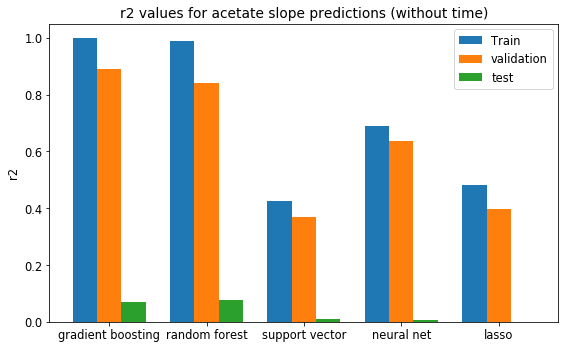

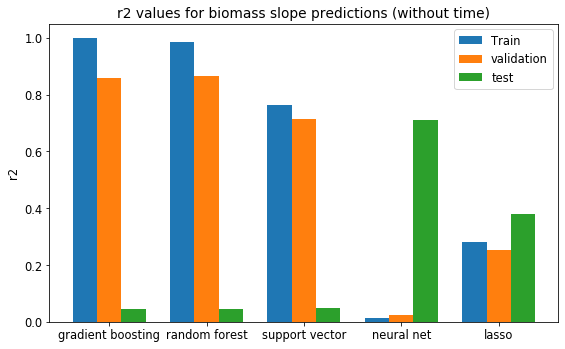

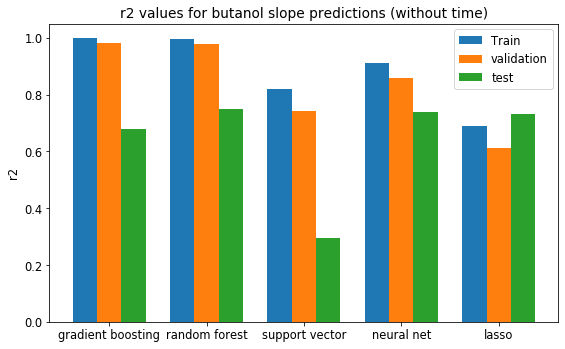

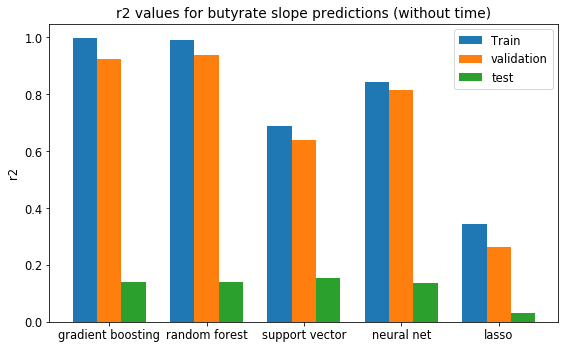

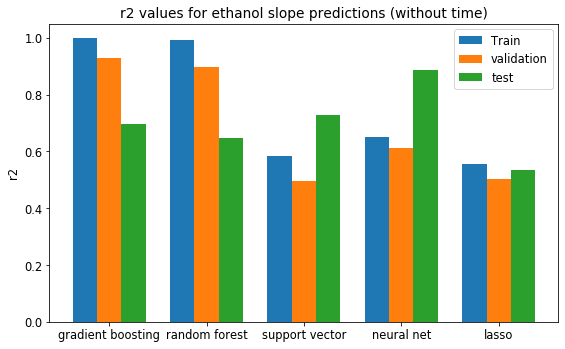

In [17]:
for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    plot_evaluation_metrics(output, 'r2')

Plot normalized mean squared error

In [18]:
# for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
#     plot_evaluation_metrics(output, 'norm_rmse')

## Plot scatterplots of slope fits
Plot alcohols

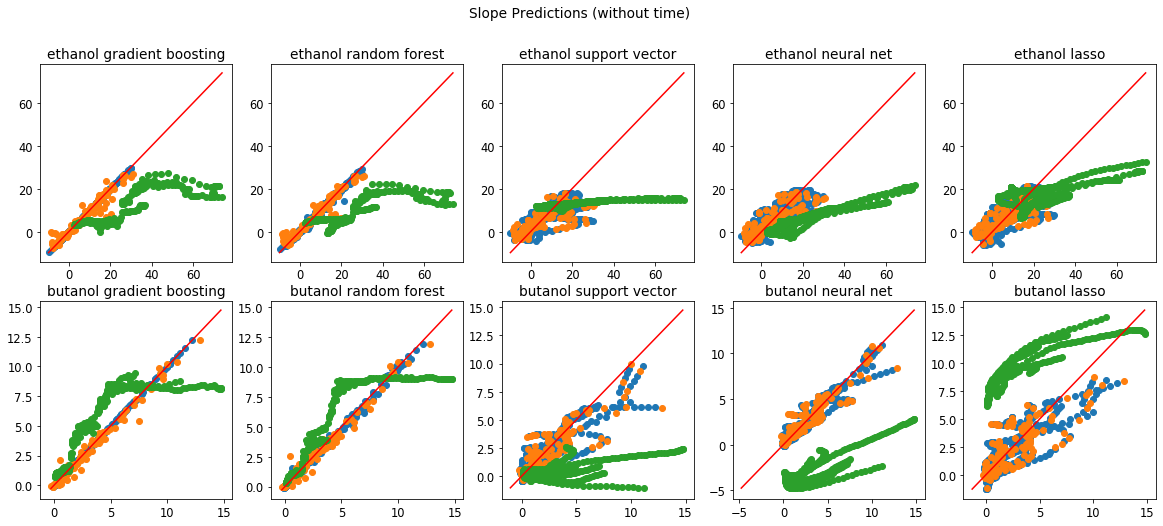

In [19]:
outputs = ['ethanol', 'butanol']
models = ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(f'Slope Predictions (without time)')

for x in range(2):
    for y in range(5):
        ax[x, y].title.set_text(f'{outputs[x]} {models[y]}')
        
        ax[x, y].scatter(train_data[outputs[x]], train_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(validation_data[outputs[x]], validation_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(test_data[outputs[x]], test_predictions[models[y]][outputs[x]])
        
        minimum = min(pd.concat([
            test_data[outputs[x]],
            validation_data[outputs[x]],
            train_data[outputs[x]], 
            test_predictions[models[y]][outputs[x]],
            validation_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        maximum = max(pd.concat([
            test_data[outputs[x]],
            validation_data[outputs[x]],
            train_data[outputs[x]],
            test_predictions[models[y]][outputs[x]],
            validation_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        ax[x, y].plot([minimum, maximum], [minimum, maximum], 'r') #row=0, col=0

plt.savefig(f'{home_dir}/figures/slope_figures_with_time/slope_scatterplots_without_time.png', dpi=100)
plt.show()

Plot others

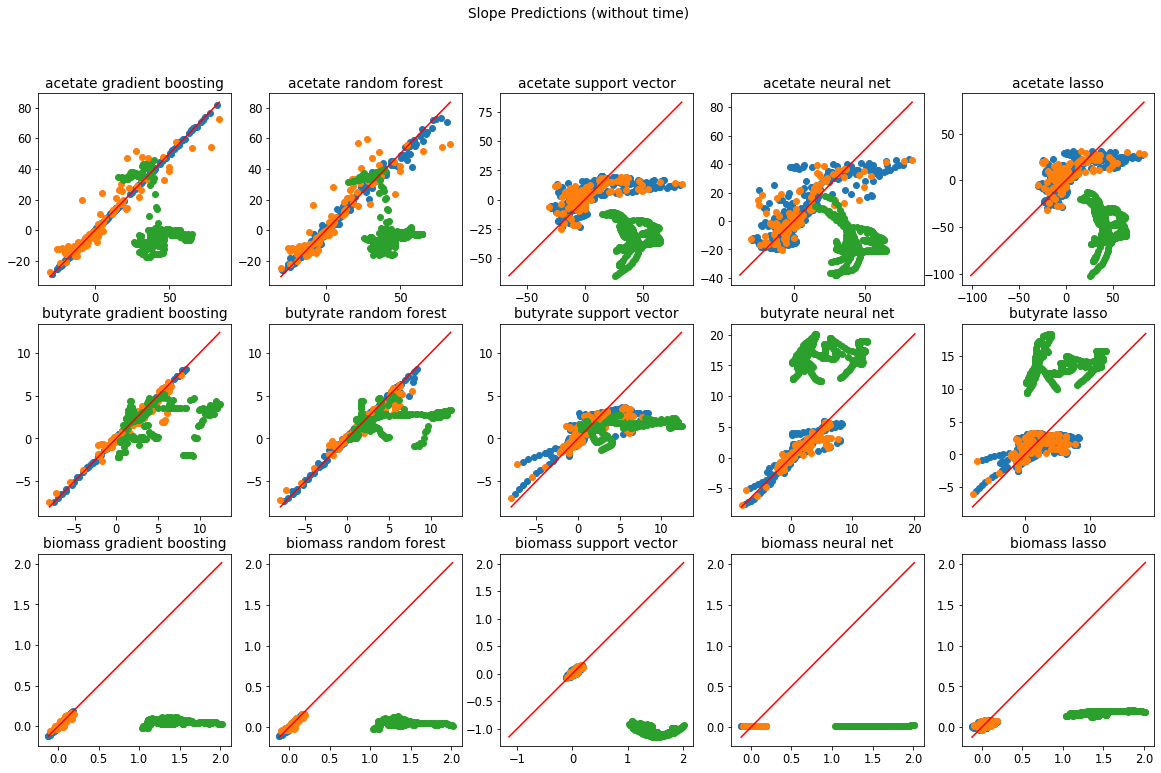

In [20]:
outputs = ['acetate', 'butyrate', 'biomass']
models = ['gradient boosting', 'random forest', 'support vector', 'neural net', 'lasso']

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(f'Slope Predictions (without time)')

for x in range(3):
    for y in range(5):
        ax[x, y].title.set_text(f'{outputs[x]} {models[y]}')
        
        ax[x, y].scatter(train_data[outputs[x]], train_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(validation_data[outputs[x]], validation_predictions[models[y]][outputs[x]])
        ax[x, y].scatter(test_data[outputs[x]], test_predictions[models[y]][outputs[x]])
        
        minimum = min(pd.concat([
            test_data[outputs[x]],
            validation_data[outputs[x]],
            train_data[outputs[x]], 
            test_predictions[models[y]][outputs[x]],
            validation_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        maximum = max(pd.concat([
            test_data[outputs[x]],
            validation_data[outputs[x]],
            train_data[outputs[x]],
            test_predictions[models[y]][outputs[x]],
            validation_predictions[models[y]][outputs[x]],
            train_predictions[models[y]][outputs[x]]
        ], axis=0))

        ax[x, y].plot([minimum, maximum], [minimum, maximum], 'r') #row=0, col=0

plt.savefig(f'{home_dir}/figures/slope_figures_without_time/slope_scatterplots_without_time_all.png', dpi=100)
plt.show()

## Feature Importance
Define a function to get feature importances

In [21]:
def get_feature_importances(model):
    outputs = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
    features = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']

    array_list = []

    for i in range(5):
        feature_importance_array = model.estimators_[i].steps[1][1].best_estimator_.feature_importances_
        array_list.append(list(feature_importance_array))
    df = pd.DataFrame(array_list, columns = features, index = outputs)  
    return df

Get feature importance values

In [22]:
model_list = [
    trained_models['gradient boosting'],
    trained_models['random forest'],
    ]

for model in model_list:
    display(get_feature_importances(model))

,acetate,biomass,butanol,butyrate,ethanol,CO,CO2,H2,flow rate
acetate,0.064658,0.148692,0.624818,0.052280,0.089332,0.001153,0.013008,0.006047,0.000011
biomass,0.367740,0.111787,0.095422,0.236845,0.147440,0.011366,0.024001,0.003970,0.001430
butanol,0.044779,0.054430,0.699751,0.026606,0.027172,0.005127,0.007065,0.135065,0.000006
butyrate,0.240157,0.179650,0.132736,0.111393,0.304915,0.000313,0.007101,0.023610,0.000125
ethanol,0.076947,0.230201,0.100456,0.033139,0.537095,0.003423,0.012838,0.005788,0.000112


,acetate,biomass,butanol,butyrate,ethanol,CO,CO2,H2,flow rate
acetate,0.068791,0.131101,0.635578,0.070956,0.070190,0.003550,0.006409,0.005151,0.008273
biomass,0.354025,0.115532,0.138760,0.220705,0.131443,0.012359,0.012085,0.014327,0.000764
butanol,0.051527,0.057718,0.697139,0.022113,0.029564,0.002246,0.003180,0.134696,0.001817
butyrate,0.144105,0.142717,0.236054,0.085449,0.335966,0.002183,0.008102,0.044927,0.000497
ethanol,0.065091,0.209282,0.101558,0.041734,0.557620,0.003663,0.012550,0.008136,0.000366


Define a function to plot feature importance

In [23]:
def plot_feature_importance_metabolites(model_name):
    model = trained_models[model_name]
    data = get_feature_importances(model)
    
    ethanol_data = data.iloc[4]
    butanol_data = data.iloc[2]
    
    ethanol_data = ethanol_data[:5]
    butanol_data = butanol_data[:5]
    
    labels = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol'] #, 'CO', 'CO2', 'H2', 'flow rate']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    rects5 = ax.bar(x - 0.5*width, ethanol_data , width, label='Ethanol Rate')
    rects3 = ax.bar(x + 0.5*width , butanol_data , width, label='Butanol Rate')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'Importance')
    ax.set_yscale('log')
    ax.set_title(f'Feature Importance for {model_name} Slope Predictions (without time)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.savefig(f'{home_dir}/figures/slope_figures_without_time/slope_feature_importance_{model_name}_metabolites_without_time.png', dpi=100)
    plt.show()

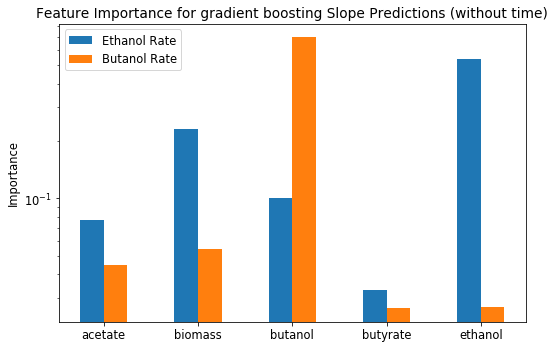

In [24]:
plot_feature_importance_metabolites('gradient boosting')

Plot feature importance gradient boosting and random forest

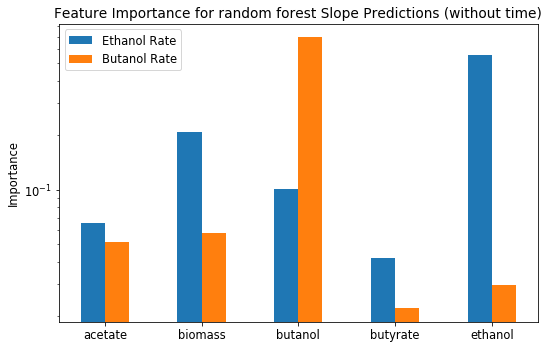

In [25]:
plot_feature_importance_metabolites('random forest')

In [26]:
def plot_feature_importance_gases(model_name):
    model = trained_models[model_name]
    data = get_feature_importances(model)
    
    ethanol_data = data.iloc[4]
    butanol_data = data.iloc[2]
    
    ethanol_data = ethanol_data[5:]
    butanol_data = butanol_data[5:]
    
    labels = ['CO', 'CO2', 'H2', 'flow rate']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,5))
    rects5 = ax.bar(x - 0.5*width, ethanol_data , width, label='Ethanol Rate')
    rects3 = ax.bar(x + 0.5*width , butanol_data , width, label='Butanol Rate')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'Importance')
    ax.set_yscale('log')
    ax.set_title(f'Feature Importance for {model_name} Slope Predictions (without time)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    fig.tight_layout()
    plt.savefig(f'{home_dir}/figures/slope_figures_without_time/slope_feature_importance_gases_{model_name}.png', dpi=100)
    plt.show()

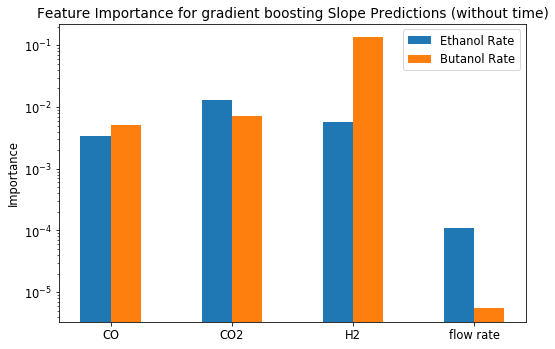

In [27]:
plot_feature_importance_gases('gradient boosting')

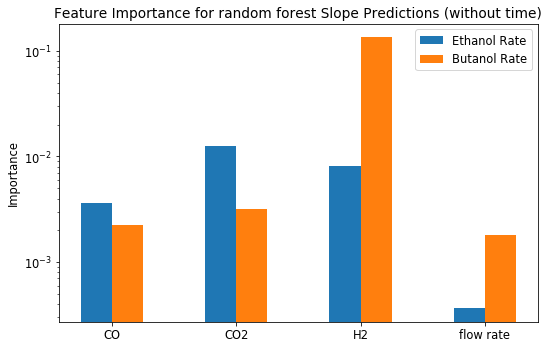

In [28]:
plot_feature_importance_gases('random forest')